# Education Data Analysis & SAP HANA Integration

This notebook performs data sanitation, feature engineering, and uploads processed education data to SAP HANA Cloud.

## Overview
- Load and clean education municipality data
- Parse percentage and population fields
- Create derived features (coverage gaps, dropout estimates)
- Validate data quality
- Upload to SAP HANA Cloud using hana_ml

## Prerequisites
- Python virtual environment with required packages
- SAP HANA Cloud credentials (set as environment variables)
- Education CSV data file

## 1. Requirements & Setup

Install required packages (run once in your terminal):
```bash
pip install pandas numpy hana-ml python-dateutil sqlalchemy matplotlib seaborn scikit-learn
```

**Note:** hana-ml requires SAP HANA client libraries and proper environment setup.

In [3]:
# Environment Variables for HANA Connection
# Set these in your environment before running:
# export HANA_HOST='your-hana-host.hana.example.com'
# export HANA_PORT='443'
# export HANA_USER='your-username'
# export HANA_PASSWORD='your-password'
# export HANA_SCHEMA='YOUR_SCHEMA'

import os

# HANA connection parameters from environment
HANA_HOST = os.getenv('HANA_HOST', '<hana-host>')
HANA_PORT = int(os.getenv('HANA_PORT', '443'))
HANA_USER = os.getenv('HANA_USER', '<hana-user>')
HANA_PASSWORD = os.getenv('HANA_PASSWORD', '<hana-password>')
HANA_SCHEMA = os.getenv('HANA_SCHEMA', '<YOUR_SCHEMA>')
HANA_TABLE = 'EDU_FEATURES'

# Data file path
CSV_PATH = 'Colombia_education_municipalities.csv'

print(f"HANA Host configured: {HANA_HOST}")
print(f"HANA Schema: {HANA_SCHEMA}")
print(f"Data file: {CSV_PATH}")

HANA Host configured: db77b804-02bd-4b60-a2a1-95a6eb8b764d.hna0.prod-us10.hanacloud.ondemand.com
HANA Schema: EDUCATION_ANALYTICS
Data file: Colombia_education_municipalities.csv


## 2. Imports and Helper Functions

In [4]:
import re
import io
from datetime import datetime
import pandas as pd
import numpy as np
from dateutil import parser

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning (for future analysis)
from sklearn.ensemble import IsolationForest, GradientBoostingRegressor

# hana_ml imports (used only for upload section)
try:
    from hana_ml import dataframe as hana_dataframe
    from hana_ml.dataframe import ConnectionContext
    HANA_AVAILABLE = True
except Exception as e:
    # If hana_ml isn't installed or HANA client missing, we still let user run local cleaning
    HANA_AVAILABLE = False
    print("hana_ml not available or not configured. Upload to HANA will be skipped unless hana_ml is installed and configured.")

# Configure visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Imports successful!")
print(f"HANA ML Available: {HANA_AVAILABLE}")

Imports successful!
HANA ML Available: True


### Helper: Convert percentage-like strings to float

Handles values like:
- "56.11%"
- "0%"
- "0,00%" (commas as decimal separator)
- empty string or NaN → returns np.nan

In [5]:
def parse_percent(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip()
    if s == '':
        return np.nan
    # Remove surrounding quotes
    s = s.strip('"')
    # If already numeric
    if re.match(r'^-?\d+(?:\.\d+)?$', s):
        return float(s)
    # Replace comma decimal with dot
    s = s.replace('%', '').replace(',', '.')
    s = s.strip()
    if s == '' or s.upper() in ('N/T', 'NT'):
        return np.nan
    try:
        return float(s)
    except Exception:
        return np.nan

# Test the function
test_values = ['56.11%', '0%', '0,00%', '', 'N/T', '45.5']
print("Testing parse_percent function:")
for val in test_values:
    print(f"  '{val}' -> {parse_percent(val)}")

Testing parse_percent function:
  '56.11%' -> 56.11
  '0%' -> 0.0
  '0,00%' -> 0.0
  '' -> nan
  'N/T' -> nan
  '45.5' -> 45.5


### Helper: Parse population integers with possible quotes/separators

In [6]:
def parse_int(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip().strip('"')
    if s == '':
        return np.nan
    # remove thousand separators (both "." and ",") but be careful with decimals
    s2 = re.sub(r"[^0-9]", "", s)
    if s2 == '':
        return np.nan
    try:
        return int(s2)
    except Exception:
        return np.nan

# Test the function
test_values = ['"1,234"', '5678', '"12.345"', '', '1.234.567']
print("Testing parse_int function:")
for val in test_values:
    print(f"  '{val}' -> {parse_int(val)}")

Testing parse_int function:
  '"1,234"' -> 1234
  '5678' -> 5678
  '"12.345"' -> 12345
  '' -> nan
  '1.234.567' -> 1234567


## 3. Load CSV and Initial Inspection

Load the education municipalities CSV file with automatic encoding detection.

In [7]:
def load_csv(path):
    """Try multiple encodings and separators to load CSV"""
    encodings = ['utf-8', 'latin-1', 'iso-8859-1']
    for enc in encodings:
        try:
            df = pd.read_csv(path, encoding=enc)
            print(f'Loaded with encoding {enc}, shape={df.shape}')
            return df
        except Exception as e:
            # try with semicolon separator
            try:
                df = pd.read_csv(path, encoding=enc, sep=';')
                print(f'Loaded with encoding {enc} and sep=";", shape={df.shape}')
                return df
            except Exception:
                pass
    raise RuntimeError('Cannot read CSV: try different encoding or check the file')

# Load the data
try:
    raw = load_csv(CSV_PATH)
    print(f"\nSuccessfully loaded {len(raw)} rows")
except Exception as e:
    print('Error loading CSV:', e)
    raw = pd.DataFrame()

Loaded with encoding utf-8, shape=(15707, 41)

Successfully loaded 15707 rows


In [8]:
# Quick peek at the data
if not raw.empty:
    print('Columns detected:', raw.columns.tolist())
    print(f'\nDataset shape: {raw.shape}')
    print('\nFirst 5 rows:')
    display(raw.head())
    
    print('\nData types:')
    print(raw.dtypes)
    
    print('\nMissing values:')
    print(raw.isnull().sum())

Columns detected: ['AÑO', 'CÓDIGO_MUNICIPIO', 'MUNICIPIO', 'CÓDIGO_DEPARTAMENTO', 'DEPARTAMENTO', 'CÓDIGO_ETC', 'ETC', 'POBLACIÓN_5_16', 'TASA_MATRICULACIÓN_5_16', 'COBERTURA_NETA', 'COBERTURA_NETA_TRANSICIÓN', 'COBERTURA_NETA_PRIMARIA', 'COBERTURA_NETA_SECUNDARIA', 'COBERTURA_NETA_MEDIA', 'COBERTURA_BRUTA', 'COBERTURA_BRUTA_TRANSICIÓN', 'COBERTURA_BRUTA_PRIMARIA', 'COBERTURA_BRUTA_SECUNDARIA', 'COBERTURA_BRUTA_MEDIA', 'TAMAÑO_PROMEDIO_DE_GRUPO', 'SEDES_CONECTADAS_A_INTERNET', 'DESERCIÓN', 'DESERCIÓN_TRANSICIÓN', 'DESERCIÓN_PRIMARIA', 'DESERCIÓN_SECUNDARIA', 'DESERCIÓN_MEDIA', 'APROBACIÓN', 'APROBACIÓN_TRANSICIÓN', 'APROBACIÓN_PRIMARIA', 'APROBACIÓN_SECUNDARIA', 'APROBACIÓN_MEDIA', 'REPROBACIÓN', 'REPROBACIÓN_TRANSICIÓN', 'REPROBACIÓN_PRIMARIA', 'REPROBACIÓN_SECUNDARIA', 'REPROBACIÓN_MEDIA', 'REPITENCIA', 'REPITENCIA_TRANSICIÓN', 'REPITENCIA_PRIMARIA', 'REPITENCIA_SECUNDARIA', 'REPITENCIA_MEDIA']

Dataset shape: (15707, 41)

First 5 rows:


,AÑO,CÓDIGO_MUNICIPIO,MUNICIPIO,CÓDIGO_DEPARTAMENTO,DEPARTAMENTO,CÓDIGO_ETC,ETC,POBLACIÓN_5_16,TASA_MATRICULACIÓN_5_16,COBERTURA_NETA,...,REPROBACIÓN,REPROBACIÓN_TRANSICIÓN,REPROBACIÓN_PRIMARIA,REPROBACIÓN_SECUNDARIA,REPROBACIÓN_MEDIA,REPITENCIA,REPITENCIA_TRANSICIÓN,REPITENCIA_PRIMARIA,REPITENCIA_SECUNDARIA,REPITENCIA_MEDIA
0,2024,5004,Abriaquí,5,Antioquia,3758.0,Antioquia (ETC),499,56.11%,56.11%,...,0.32%,0%,0%,0%,2.33%,8.41%,0%,8.51%,13%,2.33%
1,2024,15204,Cómbita,15,Boyacá,3769.0,Boyacá (ETC),1862,95.33%,95.33%,...,2.62%,0%,1.71%,4.4%,1.05%,7.94%,1.69%,4.94%,14.53%,0%
2,2024,99773,Cumaribo,99,Vichada,3832.0,Vichada (ETC),25239,50.7%,50.7%,...,15.22%,0%,20.39%,8.09%,5.7%,20.14%,0.63%,26.99%,11.05%,4.34%
3,2024,99624,Santa Rosalía,99,Vichada,3832.0,Vichada (ETC),1157,81.42%,81.42%,...,7.63%,0%,7.12%,10.92%,5.43%,13.17%,0%,15%,16.67%,2.17%
4,2024,99524,La Primavera,99,Vichada,3832.0,Vichada (ETC),2645,90.96%,90.96%,...,8.83%,0%,11%,8.84%,2.91%,13.15%,0.68%,17.38%,11.67%,3.64%



Data types:
AÑO                              int64
CÓDIGO_MUNICIPIO                 int64
MUNICIPIO                       object
CÓDIGO_DEPARTAMENTO              int64
DEPARTAMENTO                    object
CÓDIGO_ETC                     float64
ETC                             object
POBLACIÓN_5_16                  object
TASA_MATRICULACIÓN_5_16         object
COBERTURA_NETA                  object
COBERTURA_NETA_TRANSICIÓN       object
COBERTURA_NETA_PRIMARIA         object
COBERTURA_NETA_SECUNDARIA       object
COBERTURA_NETA_MEDIA            object
COBERTURA_BRUTA                 object
COBERTURA_BRUTA_TRANSICIÓN      object
COBERTURA_BRUTA_PRIMARIA        object
COBERTURA_BRUTA_SECUNDARIA      object
COBERTURA_BRUTA_MEDIA           object
TAMAÑO_PROMEDIO_DE_GRUPO        object
SEDES_CONECTADAS_A_INTERNET     object
DESERCIÓN                       object
DESERCIÓN_TRANSICIÓN            object
DESERCIÓN_PRIMARIA              object
DESERCIÓN_SECUNDARIA            object
DESERCIÓN_ME

## 4. Data Sanitation Pipeline

### 4.1 Normalize Column Names

In [9]:
def normalize_colname(s):
    """Convert column names to lowercase snake_case ASCII"""
    s = str(s)
    s = s.strip()
    # remove quotes
    s = s.strip('"')
    # replace spaces and special characters with underscore
    s = s.replace(' ', '_')
    # remove accent marks using a basic map (small list)
    accent_map = str.maketrans('ÁÉÍÓÚÑáéíóúñÜü', 'AEIOUNaeiounUu')
    s = s.translate(accent_map)
    # keep letters, numbers and underscores
    s = re.sub(r'[^0-9A-Za-z_]', '', s)
    s = s.lower()
    return s

# Apply normalization
original_cols = raw.columns.tolist()
raw.columns = [normalize_colname(c) for c in raw.columns]

print('Column name normalization:')
for orig, norm in zip(original_cols[:10], raw.columns[:10]):
    print(f"  '{orig}' -> '{norm}'")

print(f'\nAll normalized columns: {raw.columns.tolist()}')

Column name normalization:
  'AÑO' -> 'ano'
  'CÓDIGO_MUNICIPIO' -> 'codigo_municipio'
  'MUNICIPIO' -> 'municipio'
  'CÓDIGO_DEPARTAMENTO' -> 'codigo_departamento'
  'DEPARTAMENTO' -> 'departamento'
  'CÓDIGO_ETC' -> 'codigo_etc'
  'ETC' -> 'etc'
  'POBLACIÓN_5_16' -> 'poblacion_5_16'
  'TASA_MATRICULACIÓN_5_16' -> 'tasa_matriculacion_5_16'
  'COBERTURA_NETA' -> 'cobertura_neta'

All normalized columns: ['ano', 'codigo_municipio', 'municipio', 'codigo_departamento', 'departamento', 'codigo_etc', 'etc', 'poblacion_5_16', 'tasa_matriculacion_5_16', 'cobertura_neta', 'cobertura_neta_transicion', 'cobertura_neta_primaria', 'cobertura_neta_secundaria', 'cobertura_neta_media', 'cobertura_bruta', 'cobertura_bruta_transicion', 'cobertura_bruta_primaria', 'cobertura_bruta_secundaria', 'cobertura_bruta_media', 'tamano_promedio_de_grupo', 'sedes_conectadas_a_internet', 'desercion', 'desercion_transicion', 'desercion_primaria', 'desercion_secundaria', 'desercion_media', 'aprobacion', 'aprobacion_

### 4.2 Parse Percentage Columns

In [10]:
# Define which columns are percentages based on known header names
percent_cols_guess = [
    'tasa_matriculacion_5_16','cobertura_neta','cobertura_neta_transicion','cobertura_neta_primaria',
    'cobertura_neta_secundaria','cobertura_neta_media','cobertura_bruta','cobertura_bruta_transicion',
    'cobertura_bruta_primaria','cobertura_bruta_secundaria','cobertura_bruta_media',
    'sedes_conectadas_a_internet','desercion','desercion_transicion','desercion_primaria','desercion_secundaria',
    'desercion_media','aprobacion','aprobacion_transicion','aprobacion_primaria','aprobacion_secundaria',
    'aprobacion_media','reprobacion','reprobacion_transicion','reprobacion_primaria','reprobacion_secundaria',
    'reprobacion_media','repitencia','repitencia_transicion','repitencia_primaria','repitencia_secundaria',
    'repitencia_media'
]

# Keep only columns present in the dataset
percent_cols = [c for c in percent_cols_guess if c in raw.columns]
print(f'Found {len(percent_cols)} percentage columns to parse:')
print(percent_cols)

# Parse percent columns
for c in percent_cols:
    raw[c + '_pc'] = raw[c].apply(parse_percent)

print(f'\nCreated {len(percent_cols)} new numeric percentage columns (suffix: _pc)')

Found 32 percentage columns to parse:
['tasa_matriculacion_5_16', 'cobertura_neta', 'cobertura_neta_transicion', 'cobertura_neta_primaria', 'cobertura_neta_secundaria', 'cobertura_neta_media', 'cobertura_bruta', 'cobertura_bruta_transicion', 'cobertura_bruta_primaria', 'cobertura_bruta_secundaria', 'cobertura_bruta_media', 'sedes_conectadas_a_internet', 'desercion', 'desercion_transicion', 'desercion_primaria', 'desercion_secundaria', 'desercion_media', 'aprobacion', 'aprobacion_transicion', 'aprobacion_primaria', 'aprobacion_secundaria', 'aprobacion_media', 'reprobacion', 'reprobacion_transicion', 'reprobacion_primaria', 'reprobacion_secundaria', 'reprobacion_media', 'repitencia', 'repitencia_transicion', 'repitencia_primaria', 'repitencia_secundaria', 'repitencia_media']

Created 32 new numeric percentage columns (suffix: _pc)


### 4.3 Parse Population and Code Columns

In [11]:
# Parse population
if 'poblacion_5_16' in raw.columns:
    raw['poblacion_5_16_int'] = raw['poblacion_5_16'].apply(parse_int)
    print(f"Parsed 'poblacion_5_16' to integer column 'poblacion_5_16_int'")

# Parse codigo columns as strings (keep leading zeros)
codigo_cols = ['codigo_municipio','codigo_departamento','codigo_etc']
for c in codigo_cols:
    if c in raw.columns:
        raw[c] = raw[c].astype(str).str.zfill(5)
        print(f"Formatted '{c}' as zero-padded string")

print("\nSample of parsed data:")
sample_cols = [c for c in ['codigo_municipio', 'poblacion_5_16_int', 'cobertura_neta_pc', 'desercion_pc'] if c in raw.columns]
if sample_cols:
    display(raw[sample_cols].head(10))

Parsed 'poblacion_5_16' to integer column 'poblacion_5_16_int'
Formatted 'codigo_municipio' as zero-padded string
Formatted 'codigo_departamento' as zero-padded string
Formatted 'codigo_etc' as zero-padded string

Sample of parsed data:


,codigo_municipio,poblacion_5_16_int,cobertura_neta_pc,desercion_pc
0,05004,499.0,56.11,0.00
1,15204,1862.0,95.33,3.24
2,99773,25239.0,50.70,5.50
3,99624,1157.0,81.42,6.30
4,99524,2645.0,90.96,5.16
5,99001,4600.0,148.17,8.45
6,97889,562.0,46.26,8.39
7,97777,208.0,0.00,0.00
8,97666,802.0,19.95,0.00
9,97511,1666.0,54.80,7.83


### 4.4 Create Derived Features

In [12]:
# Coverage gap
if 'cobertura_neta_pc' in raw.columns:
    raw['cobertura_gap'] = 100.0 - raw['cobertura_neta_pc']
    print("Created 'cobertura_gap' (100 - net coverage)")

# Estimated absolute dropouts
if 'desercion_pc' in raw.columns and 'poblacion_5_16_int' in raw.columns:
    raw['est_dropouts_abs'] = (raw['desercion_pc'] / 100.0) * raw['poblacion_5_16_int']
    print("Created 'est_dropouts_abs' (estimated absolute dropout count)")

# Internet connectivity flag
if 'sedes_conectadas_a_internet_pc' in raw.columns:
    raw['any_internet_flag'] = raw['sedes_conectadas_a_internet_pc'].apply(
        lambda v: 1 if (not pd.isna(v) and v > 0) else 0
    )
    print("Created 'any_internet_flag' (1 if any internet connectivity)")

# Department average desertion rate
if 'desercion_pc' in raw.columns and 'codigo_departamento' in raw.columns:
    raw['dept_avg_desercion'] = raw.groupby('codigo_departamento')['desercion_pc'].transform(
        lambda g: g.mean()
    )
    print("Created 'dept_avg_desercion' (department-level average)")

print("\nDerived features created successfully!")
print(f"Dataset now has {len(raw.columns)} columns")

Created 'cobertura_gap' (100 - net coverage)
Created 'est_dropouts_abs' (estimated absolute dropout count)
Created 'any_internet_flag' (1 if any internet connectivity)
Created 'dept_avg_desercion' (department-level average)

Derived features created successfully!
Dataset now has 78 columns


### 4.5 Data Quality Flags

In [13]:
# Flag rows that are all zeros in key metrics (potential reporting issues)
key_metrics = [c + '_pc' for c in ['cobertura_neta','cobertura_bruta','desercion','aprobacion','reprobacion','repitencia'] 
               if c + '_pc' in raw.columns]

if key_metrics:
    raw['all_zero_reporting'] = raw[key_metrics].fillna(0).sum(axis=1) == 0
    print(f"Created 'all_zero_reporting' flag (checks {len(key_metrics)} metrics)")

# Basic sanity: values > 100 for net coverage
if 'cobertura_neta_pc' in raw.columns:
    raw['cobertura_neta_gt_100'] = raw['cobertura_neta_pc'].apply(
        lambda v: True if (not pd.isna(v) and v > 100.0) else False
    )
    print("Created 'cobertura_neta_gt_100' flag (net coverage > 100%)")

print("\nData quality flags created!")

Created 'all_zero_reporting' flag (checks 6 metrics)
Created 'cobertura_neta_gt_100' flag (net coverage > 100%)

Data quality flags created!


## 5. Data Quality Diagnostics

In [14]:
print('='*60)
print('DATA QUALITY REPORT')
print('='*60)

print(f'\nTotal rows: {raw.shape[0]}')
print(f'Total columns: {raw.shape[1]}')

if 'all_zero_reporting' in raw.columns:
    zero_count = int(raw['all_zero_reporting'].sum())
    print(f'\nRows with all-zero reporting: {zero_count} ({zero_count/len(raw)*100:.2f}%)')

if 'cobertura_neta_gt_100' in raw.columns:
    gt100_count = int(raw['cobertura_neta_gt_100'].sum())
    print(f'Rows with net coverage > 100%: {gt100_count} ({gt100_count/len(raw)*100:.2f}%)')

# Missing values in key columns
print('\nMissing values in key parsed columns:')
key_parsed = [c for c in ['poblacion_5_16_int', 'cobertura_neta_pc', 'desercion_pc', 'aprobacion_pc'] 
              if c in raw.columns]
if key_parsed:
    missing_df = raw[key_parsed].isnull().sum()
    for col, count in missing_df.items():
        pct = count / len(raw) * 100
        print(f"  {col}: {count} ({pct:.2f}%)")

DATA QUALITY REPORT

Total rows: 15707
Total columns: 80

Rows with all-zero reporting: 29 (0.18%)
Rows with net coverage > 100%: 2190 (13.94%)

Missing values in key parsed columns:
  poblacion_5_16_int: 6 (0.04%)
  cobertura_neta_pc: 111 (0.71%)
  desercion_pc: 142 (0.90%)
  aprobacion_pc: 25 (0.16%)


### Summary Statistics

In [15]:
# Show summary statistics for key metrics
summary_cols = [c for c in ['poblacion_5_16_int', 'cobertura_neta_pc', 'cobertura_gap', 
                             'desercion_pc', 'est_dropouts_abs', 'aprobacion_pc'] 
                if c in raw.columns]

if summary_cols:
    print('\nSummary statistics for key metrics:')
    display(raw[summary_cols].describe())


Summary statistics for key metrics:


,poblacion_5_16_int,cobertura_neta_pc,cobertura_gap,desercion_pc,est_dropouts_abs,aprobacion_pc
count,1.570100e+04,15596.000000,15596.000000,15565.000000,15565.000000,15682.000000
mean,1.062345e+04,85.226813,14.773187,3.485402,309.662943,91.545609
std,1.392115e+05,16.877964,16.877964,2.146110,1401.411601,5.284595
min,1.000000e+00,0.000000,-164.540000,0.000000,0.000000,0.000000
25%,1.407000e+03,76.420000,5.730000,1.950000,33.004800,88.440000
50%,2.939000e+03,86.040000,13.960000,3.150000,92.537500,91.915000
75%,6.236000e+03,94.270000,23.580000,4.640000,240.309400,95.430000
max,9.548263e+06,264.540000,100.000000,27.900000,58433.693000,100.000000


### Data Preview

In [16]:
# Show a cleaned preview with selected columns
preview_cols = ['year','codigo_municipio','municipio','codigo_departamento','departamento'] + \
               [c for c in raw.columns if c.endswith('_pc')][:10]
preview_cols = [c for c in preview_cols if c in raw.columns]

if preview_cols:
    print('Sample of cleaned data (first 10 rows):')
    display(raw[preview_cols].head(10))

Sample of cleaned data (first 10 rows):


,codigo_municipio,municipio,codigo_departamento,departamento,tasa_matriculacion_5_16_pc,cobertura_neta_pc,cobertura_neta_transicion_pc,cobertura_neta_primaria_pc,cobertura_neta_secundaria_pc,cobertura_neta_media_pc,cobertura_bruta_pc,cobertura_bruta_transicion_pc,cobertura_bruta_primaria_pc,cobertura_bruta_secundaria_pc
0,05004,Abriaquí,00005,Antioquia,56.11,56.11,39.53,59.13,51.52,26.51,61.92,58.14,67.79,60.61
1,15204,Cómbita,00015,Boyacá,95.33,95.33,53.64,89.15,98.88,62.10,191.51,63.58,148.84,258.59
2,99773,Cumaribo,00099,Vichada,50.70,50.70,40.14,57.71,16.95,3.85,57.74,61.32,88.33,38.03
3,99624,Santa Rosalía,00099,Vichada,81.42,81.42,70.67,82.64,54.90,22.45,90.58,117.33,108.79,85.29
4,99524,La Primavera,00099,Vichada,90.96,90.96,64.13,96.46,59.01,31.33,99.13,83.15,128.68,89.36
5,99001,Puerto Carreño,00099,Vichada,148.35,148.17,114.02,169.11,81.25,29.10,158.74,140.43,235.60,121.40
6,97889,Yavaraté,00097,Vaupés,46.26,46.26,48.48,51.56,24.29,15.96,50.89,90.91,69.78,35.71
7,97777,Papunaua,00097,Vaupés,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,97666,Taraira,00097,Vaupés,19.95,19.95,14.29,29.83,0.00,0.00,20.82,30.16,50.17,0.00
9,97511,Pacoa,00097,Vaupés,54.80,54.80,14.29,54.88,25.09,5.25,72.87,38.10,98.78,69.53


## 6. Basic Visualizations

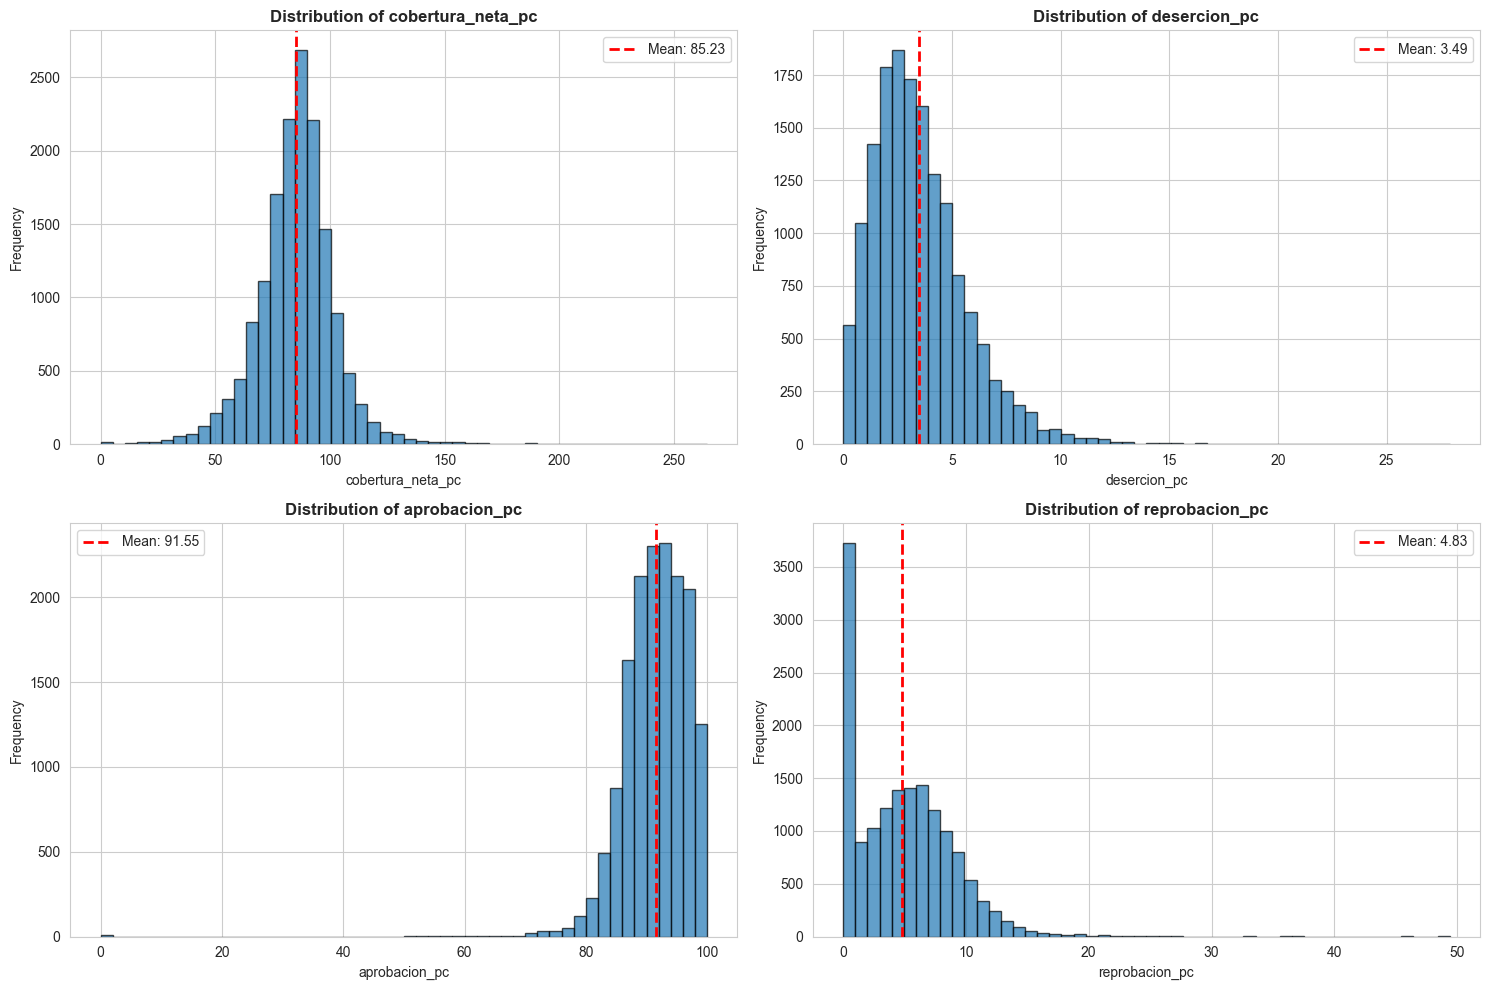

Visualizations created successfully!


In [17]:
# Distribution of key metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

plot_cols = [c for c in ['cobertura_neta_pc', 'desercion_pc', 'aprobacion_pc', 'reprobacion_pc'] 
             if c in raw.columns]

for idx, col in enumerate(plot_cols[:4]):
    ax = axes[idx // 2, idx % 2]
    data = raw[col].dropna()
    ax.hist(data, bins=50, edgecolor='black', alpha=0.7)
    ax.set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax.axvline(data.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {data.mean():.2f}')
    ax.legend()

plt.tight_layout()
plt.show()

print("Visualizations created successfully!")

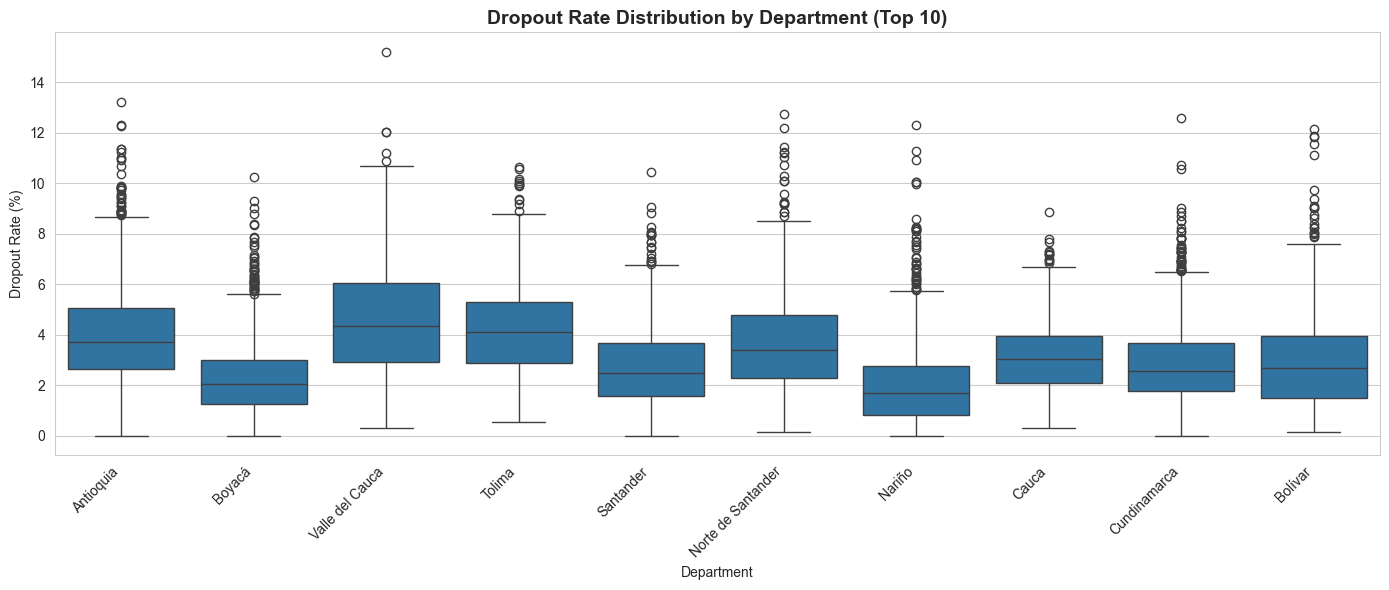

In [18]:
# Box plots for key metrics by department (if department column exists)
if 'departamento' in raw.columns and 'desercion_pc' in raw.columns:
    # Get top 10 departments by count
    top_depts = raw['departamento'].value_counts().head(10).index
    plot_data = raw[raw['departamento'].isin(top_depts)]
    
    plt.figure(figsize=(14, 6))
    sns.boxplot(data=plot_data, x='departamento', y='desercion_pc')
    plt.xticks(rotation=45, ha='right')
    plt.title('Dropout Rate Distribution by Department (Top 10)', fontsize=14, fontweight='bold')
    plt.xlabel('Department')
    plt.ylabel('Dropout Rate (%)')
    plt.tight_layout()
    plt.show()

## 7. Export Cleaned Data

In [19]:
# Save cleaned CSV
cleaned_path = 'education_cleaned.csv'
raw.to_csv(cleaned_path, index=False)
print(f'Cleaned CSV saved to: {cleaned_path}')
print(f'File size: {os.path.getsize(cleaned_path) / 1024:.2f} KB')
print(f'Rows: {len(raw)}, Columns: {len(raw.columns)}')

Cleaned CSV saved to: education_cleaned.csv
File size: 7539.77 KB
Rows: 15707, Columns: 80


## 8. Upload to SAP HANA Cloud

This section uploads the cleaned DataFrame to SAP HANA Cloud using hana_ml.

**Prerequisites:**
- SAP HANA client libraries installed
- Environment variables set (HANA_HOST, HANA_PORT, HANA_USER, HANA_PASSWORD, HANA_SCHEMA)
- Network connectivity to HANA Cloud instance

In [20]:
if HANA_AVAILABLE:
    print('Attempting connection to SAP HANA Cloud...')
    print(f'Host: {HANA_HOST}')
    print(f'Port: {HANA_PORT}')
    print(f'Schema: {HANA_SCHEMA}')
    print(f'Table: {HANA_TABLE}')
    
    try:
        # Create connection
        conn = ConnectionContext(
            address=HANA_HOST,
            port=HANA_PORT,
            user=HANA_USER,
            password=HANA_PASSWORD
        )
        print('✓ Connected to HANA Cloud successfully!')
        print(f'HANA Version: {conn.hana_version()}')
        
        # Upload DataFrame to HANA
        print(f'\nUploading {len(raw)} rows to HANA...')
        hana_df = hana_dataframe.create_dataframe_from_pandas(
            connection_context=conn,
            pandas_df=raw,
            table_name=HANA_TABLE,
            schema=HANA_SCHEMA,
            force=True
        )
        
        print(f'✓ Successfully uploaded data to {HANA_SCHEMA}.{HANA_TABLE}')
        print(f'Table shape in HANA: {hana_df.shape}')
        
        # Verify upload
        print('\nFirst 5 rows from HANA table:')
        display(hana_df.head(5).collect())
        
        # Close connection
        conn.close()
        print('\n✓ Connection closed')
        
    except Exception as e:
        print(f'✗ Error connecting or uploading to HANA: {e}')
        print('\nTroubleshooting tips:')
        print('1. Verify HANA credentials in environment variables')
        print('2. Check network connectivity to HANA Cloud instance')
        print('3. Ensure SAP HANA client libraries are properly installed')
        print('4. Verify schema and table permissions')
        print('\nAlternatively, use the exported CSV file with HANA tools (Web IDE/Cockpit/hdbsql)')
else:
    print('\n⚠ Skipping HANA upload because hana_ml is not available.')
    print('\nTo enable HANA upload:')
    print('1. Install hana-ml: pip install hana-ml')
    print('2. Install SAP HANA client libraries')
    print('3. Set environment variables for HANA connection')
    print('4. Re-run this cell')
    print('\nAlternatively, use the exported CSV file:', cleaned_path)

Attempting connection to SAP HANA Cloud...
Host: db77b804-02bd-4b60-a2a1-95a6eb8b764d.hna0.prod-us10.hanacloud.ondemand.com
Port: 443
Schema: EDUCATION_ANALYTICS
Table: EDU_FEATURES
✓ Connected to HANA Cloud successfully!
HANA Version: 4.00.000.00.1762271598 (fa/CE2025.28)

Uploading 15707 rows to HANA...


100%|██████████| 1/1 [00:04<00:00,  4.92s/it]


✓ Successfully uploaded data to EDUCATION_ANALYTICS.EDU_FEATURES
Table shape in HANA: [15707, 80]

First 5 rows from HANA table:


,ano,codigo_municipio,municipio,codigo_departamento,departamento,codigo_etc,etc,poblacion_5_16,tasa_matriculacion_5_16,cobertura_neta,...,repitencia_primaria_pc,repitencia_secundaria_pc,repitencia_media_pc,poblacion_5_16_int,cobertura_gap,est_dropouts_abs,any_internet_flag,dept_avg_desercion,all_zero_reporting,cobertura_neta_gt_100
0,2024,05004,Abriaquí,00005,Antioquia,3758.0,Antioquia (ETC),499,56.11%,56.11%,...,8.51,13.00,2.33,499.0,43.89,0.0000,0,3.978918,0,0
1,2024,15204,Cómbita,00015,Boyacá,3769.0,Boyacá (ETC),1862,95.33%,95.33%,...,4.94,14.53,0.00,1862.0,4.67,60.3288,0,2.286719,0,0
2,2024,99773,Cumaribo,00099,Vichada,3832.0,Vichada (ETC),25239,50.7%,50.7%,...,26.99,11.05,4.34,25239.0,49.30,1388.1450,0,6.296607,0,0
3,2024,99624,Santa Rosalía,00099,Vichada,3832.0,Vichada (ETC),1157,81.42%,81.42%,...,15.00,16.67,2.17,1157.0,18.58,72.8910,0,6.296607,0,0
4,2024,99524,La Primavera,00099,Vichada,3832.0,Vichada (ETC),2645,90.96%,90.96%,...,17.38,11.67,3.64,2645.0,9.04,136.4820,0,6.296607,0,0



✓ Connection closed


## 9. Next Steps & Analysis Ideas

### Recommended Next Steps:

1. **Exploratory Data Analysis (EDA)**
   - Create correlation matrices for key metrics
   - Analyze temporal trends if year data is available
   - Identify outliers and anomalies

2. **Anomaly Detection**
   - Use IsolationForest to identify municipalities with unusual patterns
   - Flag potential data quality issues
   - Investigate municipalities with extreme values

3. **Predictive Modeling**
   - Build GradientBoostingRegressor to predict dropout rates
   - Identify key factors influencing educational outcomes
   - Create risk scores for municipalities

4. **Geographic Analysis**
   - Enrich data with geographic coordinates
   - Create choropleth maps using geopandas/folium
   - Analyze spatial patterns and clusters

5. **SAP HANA Advanced Analytics**
   - Use HANA APL (Automated Predictive Library) for in-database modeling
   - Create predictive models directly in HANA
   - Generate automated insights and recommendations

### Sample Analysis Code (Uncomment to run):

In [ ]:
# # Example: Correlation analysis
# numeric_cols = raw.select_dtypes(include=[np.number]).columns
# correlation_matrix = raw[numeric_cols].corr()
# 
# plt.figure(figsize=(12, 10))
# sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
# plt.title('Correlation Matrix of Numeric Features')
# plt.tight_layout()
# plt.show()

In [ ]:
# # Example: Anomaly detection with IsolationForest
# if 'desercion_pc' in raw.columns and 'cobertura_neta_pc' in raw.columns:
#     features = raw[['desercion_pc', 'cobertura_neta_pc', 'aprobacion_pc']].dropna()
#     
#     iso_forest = IsolationForest(contamination=0.1, random_state=42)
#     anomalies = iso_forest.fit_predict(features)
#     
#     print(f"Detected {(anomalies == -1).sum()} anomalies out of {len(features)} records")

---

## Summary

✓ Data loaded and sanitized  
✓ Column names normalized  
✓ Percentage and population fields parsed  
✓ Derived features created  
✓ Data quality flags added  
✓ Cleaned data exported to CSV  
✓ Data uploaded to SAP HANA Cloud (if configured)  

**Notebook execution complete!**